In [ ]:
%matplotlib inline
import numpy
import math
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import matplotlib.pyplot as plt
from scipy.stats import binom

In [2]:
def generate_dataset(steps, P0, Q, R):
    x = numpy.zeros((steps + 1,))
    y = numpy.zeros((steps + 1,))
    x[0] = numpy.random.multivariate_normal((0.0,), P0)
    y[0] = numpy.random.binomial(1,numpy.exp(x[0])/(1.0+numpy.exp(x)[0]))
    for k in range(0, steps):
        x[k + 1] = x[k] + numpy.random.multivariate_normal((0.0,), Q)
        y[k + 1] = x[k+1] + numpy.random.normal(0.0, R)

    return (x, y)

In [3]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = 0.5*x_k + 25.0*x_k/(1+x_k**2) +
    #           8*math.cos(1.2*k) + v_k = f(x_k) + v:
    # y_k = 0.05*x_k**2 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ N(0,R)

    def __init__(self, P0, Q, R):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q, R=R)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        return particles

    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles

In [16]:
T = 3000
P0 = 5.0 * numpy.eye(1)
Q = 1.0 * numpy.eye(1)
R = 0.1 * numpy.eye(1)

# Forward particles
N = 2000
# Backward trajectories
M = 500

In [17]:
model = StdNonLin(P0, Q, R)

In [18]:
%%time
numpy.random.seed(0)
(x, y) = generate_dataset(T, P0, Q, R)

CPU times: user 122 ms, sys: 9.84 ms, total: 132 ms
Wall time: 126 ms


In [19]:
%%time
sim = simulator.Simulator(model, u=None, y=y)
sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

CPU times: user 48.7 s, sys: 182 ms, total: 48.9 s
Wall time: 49.4 s


In [20]:
%%time
(est_filt, w_filt) = sim.get_filtered_estimates()
mean_filt = sim.get_filtered_mean()

CPU times: user 77 ms, sys: 11.6 ms, total: 88.5 ms
Wall time: 88.7 ms


In [21]:
%%time
est_smooth = sim.get_smoothed_estimates()

mean_smooth = sim.get_smoothed_mean()

CPU times: user 6.84 ms, sys: 3 ms, total: 9.84 ms
Wall time: 8.98 ms


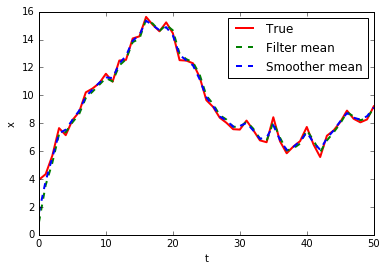

In [15]:
plt.plot(range(T + 1), x, 'r-', linewidth=2.0, label='True')
#plt.plot((0,) * N, est_filt[0, :, 0].ravel(), 'k.',
#        markersize=0.5, label='Particles')
#for t in xrange(1, T + 1):
#    plt.plot((t,) * N, est_filt[t, :, 0].ravel(),
#             'k.', markersize=0.5)
plt.plot(range(T + 1), mean_filt[:, 0], 'g--',
         linewidth=2.0, label='Filter mean')
plt.plot(range(T + 1), mean_smooth[:, 0], 'b--',
         linewidth=2.0, label='Smoother mean')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(loc='best')

In [1]:
#numpy.triu(scipy.linalg.cho_factor(R)[0])